# Libraries to be imported

In [2]:
import numpy as np
import tensorflow as tf
import pandas as pd
pd.options.mode.chained_assignment=None
import seaborn as sns
from matplotlib.pyplot import rcParams
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from scipy.signal import butter, sosfiltfilt
from ecg_detectors.ecgdetectors import panPeakDetect, searchBack
from sklearn.preprocessing import StandardScaler
import wfdb
import scipy.signal as signal
import peakutils
import os

%matplotlib inline

sns.set(style='whitegrid', palette='muted')
rcParams['figure.figsize']=14,8
np.random.seed(1)
tf.random.set_seed(1)
print(tf.__version__)

import warnings
warnings.filterwarnings('ignore')

2.1.0


# Loading the dataset

In [3]:
flist = os.listdir('../data/ECGdata/Person_90/')
flist = [file for file in flist if file.endswith('.dat')]

In [4]:
records={}
flist = os.listdir('../data/ECGdata/Person_90/')
flist = [file for file in flist if file.endswith(".dat")]   
for file in flist:
    records[file] = wfdb.rdrecord('../data/ECGdata/Person_90/'+file[:-4],channels=[1])

In [5]:
df={}
for rec in records:
    df[rec] = pd.DataFrame(records[rec].p_signal[:],columns=['ECG1'])

In [ ]:
for rec in records:
    df[rec].insert(0, 'Time', range(0,len(df[rec])))

# Splitting the data to train and test data

In [7]:
train_size={}
test_size={}
for rec in records:
    train_size[rec]=int(len(df[rec])*0.8)
    test_size[rec]=len(df[rec])-train_size[rec]

In [8]:
train,test={},{}
for rec in records:
    train[rec], test[rec] = df[rec].iloc[0:train_size[rec]], df[rec].iloc[train_size[rec]:]

# Data Processing

In [10]:
scaler={}
for rec in records:
    scaler[rec] = StandardScaler()
    scaler[rec] = scaler[rec].fit(train[rec][['ECG1']])

In [11]:
for rec in records:
    train[rec]['ECG1']=scaler[rec].transform(train[rec][['ECG1']])
    test[rec]['ECG1']=scaler[rec].transform(test[rec][['ECG1']])

In [12]:
def create_sequences(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i+time_steps])
    return np.array(Xs),np.array(ys)

In [13]:
time_steps=50

X_train, y_train={},{}
X_test, y_test={},{}

for rec in records:
    X_train[rec], y_train[rec] = create_sequences(train[rec][['ECG1']],train[rec].ECG1,time_steps)
    X_test[rec], y_test[rec] = create_sequences(test[rec][['ECG1']],test[rec].ECG1,time_steps)

In [14]:
time_steps,num_features={},{}

for rec in records:
    time_steps[rec] = X_train[rec].shape[1]
    num_features[rec] = X_train[rec].shape[2]

# Data Modeling

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

model={}
for rec in records:
    model[rec] = Sequential([
        LSTM(128,input_shape=(time_steps[rec],num_features[rec])),
        Dropout(0.2),
        RepeatVector(time_steps[rec]),
        LSTM(128,return_sequences=True),
        Dropout(0.2),
        TimeDistributed(Dense(num_features[rec]))
    ])

    model[rec].compile(loss="mae", optimizer="adam")

In [16]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3,mode='min')

history = {}
for rec in records:
    history[rec] = model[rec].fit(
        X_train[rec],y_train[rec],
        epochs = 100,
        batch_size=32,
        validation_split=0.1,
        callbacks = [es],
        shuffle=False
    )

Train on 7155 samples, validate on 795 samples
Epoch 1/100
7155/7155 [==============================] - 14s 2ms/sample - loss: 0.2461 - val_loss: 0.1163
Epoch 2/100
7155/7155 [==============================] - 11s 2ms/sample - loss: 0.1274 - val_loss: 0.0729
Epoch 3/100
7155/7155 [==============================] - 11s 2ms/sample - loss: 0.0965 - val_loss: 0.0655
Epoch 4/100
7155/7155 [==============================] - 12s 2ms/sample - loss: 0.0903 - val_loss: 0.0500
Epoch 5/100
7155/7155 [==============================] - 11s 2ms/sample - loss: 0.0796 - val_loss: 0.0424
Epoch 6/100
7155/7155 [==============================] - 11s 2ms/sample - loss: 0.0755 - val_loss: 0.0398
Epoch 7/100
7155/7155 [==============================] - 12s 2ms/sample - loss: 0.0764 - val_loss: 0.0426
Epoch 8/100
7155/7155 [==============================] - 11s 2ms/sample - loss: 0.0691 - val_loss: 0.0424
Epoch 9/100
7155/7155 [==============================] - 11s 2ms/sample - loss: 0.0739 - val_loss: 0.0307

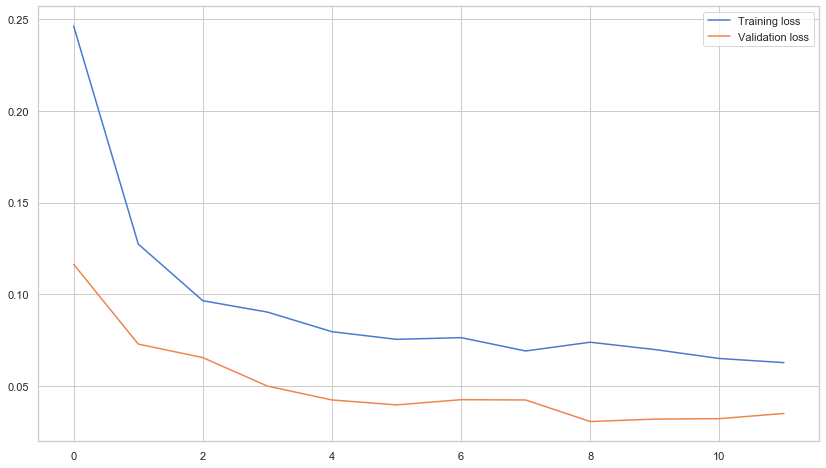

In [17]:
plt.plot(history['rec_2.dat'].history['loss'],label="Training loss")
plt.plot(history['rec_2.dat'].history['val_loss'],label="Validation loss")
plt.legend()

In [18]:
X_train_pred = {}
train_mae_loss = {}
for rec in records:
    X_train_pred[rec] = model[rec].predict(X_train[rec])
    train_mae_loss[rec] = pd.DataFrame(np.mean(np.abs(X_train_pred[rec]-X_train[rec]),axis=1),columns=['Error'])

In [19]:
for rec in records:
    model[rec].evaluate(X_test[rec],y_test[rec])

1950/1950 [==============================] - 1s 479us/sample - loss: 0.0701


# Plotting the training loss

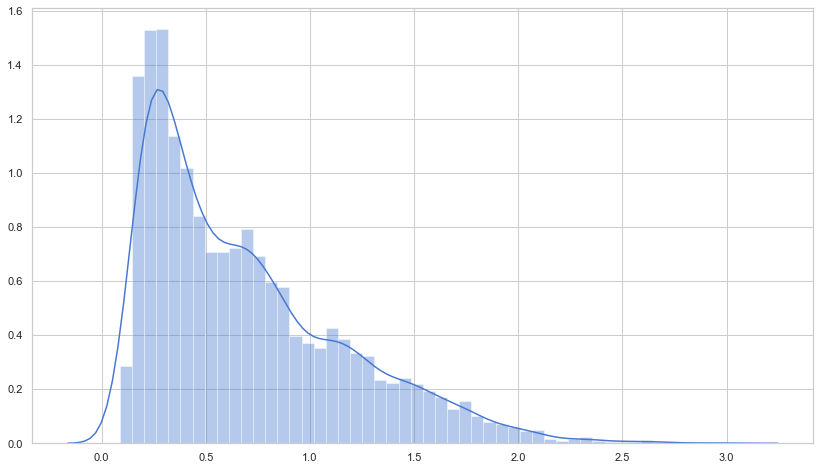

In [20]:
sns.distplot(train_mae_loss['rec_1.dat'], bins=50, kde=True)

# Obtain the Threshold value which is a Hyper-Parameter

In [21]:
threshold = {}
for rec in records:
    threshold[rec] = max(train_mae_loss[rec].Error)-0.5

In [22]:
X_test_pred = {}
test_mae_loss = {}
for rec in records:
    X_test_pred[rec] = model[rec].predict(X_test[rec])
    test_mae_loss[rec]=np.mean(np.abs(X_test_pred[rec] - X_test[rec]), axis=1)

In [23]:
len(train_mae_loss['rec_1.dat'])

7950

In [24]:
test_score_df = {}
train_score_df = {}
for rec in records:
    test_score_df[rec] = pd.DataFrame(test[rec][:len(test[rec])-time_steps[rec]])
    train_score_df[rec] = pd.DataFrame(train[rec][:len(train[rec])-time_steps[rec]])

In [28]:
for rec in records:
    test_score_df[rec]['loss']=test_mae_loss[rec]
    train_score_df[rec]['loss']=train_mae_loss[rec]
    test_score_df[rec]['threshold']=threshold[rec]
    train_score_df[rec]['threshold']=threshold[rec]
    test_score_df[rec]['anomaly']=test_score_df[rec].loss > test_score_df[rec].threshold
    train_score_df[rec]['anomaly']=train_score_df[rec].loss > train_score_df[rec].threshold
    test_score_df[rec]['ECG1']=test[rec][:].ECG1
    train_score_df[rec]['ECG1']=train[rec][:].ECG1

# Plotting the Records with its Threshold Values

In [30]:
fig = go.Figure()

for rec in records:
    fig.add_trace(go.Scatter(
    x=train[rec][:].Time,
    y=train_score_df[rec].loss,
    mode='lines',
    name='Test_loss'+str(rec)
    ))

    fig.add_trace(go.Scatter(
    x=train[rec][:].Time,
    y=train_score_df[rec].threshold,
    mode='lines',
    name='Threshold'+str(rec)
    ))

    fig.update_layout(
    title="Anomaly peaks:",
    xaxis_title="Time",
    yaxis_title="Values",
    showlegend=True)
fig.show()

In [31]:
fig = go.Figure()

for rec in records:
    
    fig.add_trace(go.Scatter(
    x=train[rec][:time_steps[rec]].Time,
    y=train_score_df[rec].loss,
    mode='lines',
    name='Train_loss'+str(rec)
    ))
    fig.add_trace(go.Scatter(
    x=train[rec][:time_steps[rec]].Time,
    y=train_score_df[rec].threshold,
    mode='lines',
    name='Threshold'+str(rec)
    ))

    fig.update_layout(
    title="Anomaly peaks:",
    xaxis_title="Time",
    yaxis_title="Values",
    showlegend=True)
fig.show()

In [32]:
anomalies_train,anomalies_test = {},{}
for rec in records:
    anomalies_test[rec] = test_score_df[rec][test_score_df[rec].anomaly == True]
    anomalies_train[rec] = train_score_df[rec][train_score_df[rec].anomaly == True]

In [34]:
anomalies_train

{'rec_2.dat':       Time      ECG1      loss  threshold  anomaly
 313    313  1.773569  2.341996   2.309084     True
 314    314  1.826035  2.487047   2.309084     True
 315    315  1.930966  2.490705   2.309084     True
 316    316  2.088364  2.314611   2.309084     True
 3095  3095  2.508091  2.384401   2.309084     True
 3096  3096  2.560557  2.385161   2.309084     True
 3097  3097  2.560557  2.359346   2.309084     True
 3344  3344 -0.062736  2.367244   2.309084     True
 3345  3345 -0.167668  2.500835   2.309084     True
 3346  3346 -0.220134  2.403505   2.309084     True
 3501  3501  2.193296  2.364260   2.309084     True
 3502  3502  2.088364  2.474752   2.309084     True
 3503  3503  1.983432  2.448067   2.309084     True
 3504  3504  1.878501  2.361388   2.309084     True
 4471  4471 -0.692326  2.495752   2.309084     True
 4472  4472 -0.692326  2.613868   2.309084     True
 4473  4473 -0.587395  2.626350   2.309084     True
 4474  4474 -0.377531  2.464686   2.309084     True

# Combining test_data anomalies and train_data anomalies and plotting

In [58]:
sx1,sy1,sx2,sy2,ax1,ax2,ay1,ay2={},{},{},{},{},{},{},{}
for rec in records:
    sx1[rec]=test[rec][time_steps[rec]:].Time
    sy1[rec]=scaler[rec].inverse_transform(test[rec][time_steps[rec]:].ECG1)
    sx2[rec]=train[rec][time_steps[rec]:].Time
    sy2[rec]=scaler[rec].inverse_transform(train[rec][time_steps[rec]:].ECG1)
    ax1[rec]=anomalies_test[rec].Time
    ax2[rec]=anomalies_train[rec].Time
    ay1[rec]=scaler[rec].inverse_transform(anomalies_test[rec].ECG1)
    ay2[rec]=scaler[rec].inverse_transform(anomalies_train[rec].ECG1)

In [60]:
fig = go.Figure()

for rec in records:
    fig.add_trace(go.Scatter(
    x=np.concatenate((np.array(sx2[rec]),np.array(sx1[rec])),axis=0),
    y=np.concatenate((np.array(sy2[rec]),np.array(sy1[rec])),axis=0),
    mode='lines',
    name='ECG1:'+str(rec)
    ))
    fig.add_trace(go.Scatter(
    x=np.concatenate((np.array(ax2[rec]),np.array(ax1[rec])),axis=0),
    y=np.concatenate((np.array(ay2[rec]),np.array(ay1[rec])),axis=0),
    mode='markers',
    name='Anomaly'+str(rec)
    ))

    fig.update_layout(showlegend=True)
    
fig.show()